# Klasifikasi Sleep Stage dari Sinyal PSG/EEG dengan Deep Learning  

Notebook ini menyajikan hasil eksplorasi awal (EDA) terhadap dataset polysomnography (PSG) yang digunakan dalam tugas mata kuliah Machine Learning. Fokus analisis adalah memahami struktur dataset, distribusi label *sleep stage*, kualitas sinyal mentah, serta karakteristik frekuensi sinyal EEG sebelum masuk ke tahap preprocessing dan pemodelan deep learning.

Anggota Kelompok:
- Muhammad Wildan Kamil - 140810220009
- Nurkahfi Amran Rahmada - 140810220020
- Muhammad Ichsan Firdaus - 140810220025

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 64.1 MB/s eta 0:00:00


In [ ]:
# === EDA Sleep EEG - Setup ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [ ]:
ALICE, BOB = 0, 1
[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

print("File Alice:", alice_files)
print("File Bob  :", bob_files)

raw_train = mne.io.read_raw_edf(
    alice_files[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error"
)
annot_train = mne.read_annotations(alice_files[1])
raw_train.set_annotations(annot_train, emit_warning=False)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating /root/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 40.4GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 2.58MB/s]
100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 47.9GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 4.13MB/s]

Download complete in 05m51s (94.8 MB)


File Alice: ['/root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf', '/root/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf']
File Bob  : ['/root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf', '/root/mne_data/physionet-sleep-data/SC4011EH-Hypnogram.edf']


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>

## Deskripsi Dataset

Dataset yang digunakan dalam penelitian ini merupakan bagian dari **Sleep Physiological Dataset** yang disediakan oleh Physionet. Dataset ini berisi rekaman **polysomnography (PSG)** nocturnal penuh dari beberapa subjek sehat. Pada tugas ini digunakan 50 subjek, di antaranya **subjek 0 (Alice)** dan **subjek 1 (Bob)**, masing-masing dengan satu sesi perekaman tidur malam penuh. Setiap subjek memiliki dua berkas utama, yaitu berkas sinyal (format EDF) dan berkas anotasi hipnogram yang memuat label *sleep stage*.

Rekaman PSG pada subjek Alice terdiri dari 7 kanal dengan komposisi sebagai berikut:

- **2 kanal EEG** (Fpz–Cz dan Pz–Oz)
- **1 kanal EOG** (horizontal)
- **1 kanal EMG submental**
- **1 kanal respirasi oro-nasal**
- **1 kanal temperatur** (rectal)
- **1 kanal event marker** sebagai penanda anotasi

Struktur ini mencerminkan konfigurasi PSG dasar pada studi tidur, di mana EEG digunakan untuk mengidentifikasi pola osilasi neural, EOG untuk mendeteksi gerakan bola mata (khususnya fase REM), EMG untuk menganalisis tonus otot, sedangkan kanal respirasi, temperatur, dan event marker memberikan informasi fisiologis pendukung.

PSG direkam menggunakan **frekuensi sampling 100 Hz**, konsisten pada kedua subjek. Durasi total rekaman untuk Alice mencapai **79.500 detik** atau sekitar **22,08 jam**, sementara subjek Bob memiliki durasi sekitar **23,35 jam**. Durasi ini umum pada dataset tidur raw karena mencakup periode sebelum tidur, waktu tidur utama, serta periode bangun kembali.


In [ ]:
n_channels = raw_train.info["nchan"]
sfreq = raw_train.info["sfreq"]
ch_names = raw_train.ch_names

print("Jumlah channel :", n_channels)
print("Sampling rate  :", sfreq, "Hz")
print("Contoh nama channel:", ch_names)

n_samples = raw_train.n_times
duration_sec = n_samples / sfreq
print("Durasi Alice   :", duration_sec/3600, "jam")

raw_test = mne.io.read_raw_edf(
    bob_files[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error"
)
duration_sec_test = raw_test.n_times / raw_test.info["sfreq"]
print("Durasi Bob     :", duration_sec_test/3600, "jam")

annot_test = mne.read_annotations(bob_files[1])
raw_test.set_annotations(annot_test, emit_warning=False)

Jumlah channel : 7
Sampling rate  : 100.0 Hz
Contoh nama channel: ['Fpz-Cz', 'Pz-Oz', 'horizontal', 'oro-nasal', 'submental', 'rectal', 'Event marker']
Durasi Alice   : 22.083333333333332 jam
Durasi Bob     : 23.35 jam


<RawEDF | SC4011E0-PSG.edf, 7 x 8406000 (84060.0 s), ~448.9 MiB, data loaded>

Hasil eksekusi kode di atas mengonfirmasi bahwa kedua subjek memiliki jumlah kanal yang sama (7 kanal) dengan frekuensi sampling 100 Hz, serta durasi perekaman yang berada pada kisaran 22–23 jam per subjek.

,Channel,Type
0,Fpz-Cz,eeg
1,Pz-Oz,eeg
2,horizontal,eog
3,oro-nasal,resp
4,submental,emg
5,rectal,temperature
6,Event marker,stim


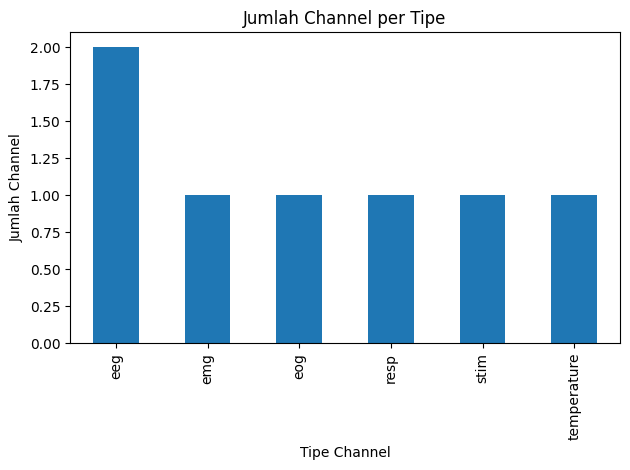

In [ ]:
channel_types = [mne.channel_type(raw_train.info, i) for i in range(n_channels)]
df_channels = pd.DataFrame({"Channel": ch_names, "Type": channel_types})
display(df_channels)

type_counts = df_channels["Type"].value_counts().sort_index()

plt.figure()
type_counts.plot(kind="bar")
plt.title("Jumlah Channel per Tipe")
plt.xlabel("Tipe Channel")
plt.ylabel("Jumlah Channel")
plt.tight_layout()
plt.show()

Gambar "Jumlah Channel per Tipe" menunjukkan bahwa rekaman PSG terdiri dari dua kanal EEG, satu kanal EOG, satu kanal EMG, satu kanal respirasi, satu kanal temperatur, dan satu kanal event marker. Komposisi ini konsisten dengan konfigurasi polysomnography standar yang digunakan dalam analisis tidur.

## Exploratory Data Analysis (EDA)

Bagian ini menyajikan eksplorasi lebih lanjut terhadap anotasi *sleep stage*, kualitas sinyal mentah, serta karakteristik statistik dan spektral sinyal EEG yang menjadi dasar bagi tahap preprocessing dan pemodelan.

,Stage,Count
0,Sleep stage 1,24
1,Sleep stage 2,40
2,Sleep stage 3,48
3,Sleep stage 4,23
4,Sleep stage ?,1
5,Sleep stage R,6
6,Sleep stage W,12


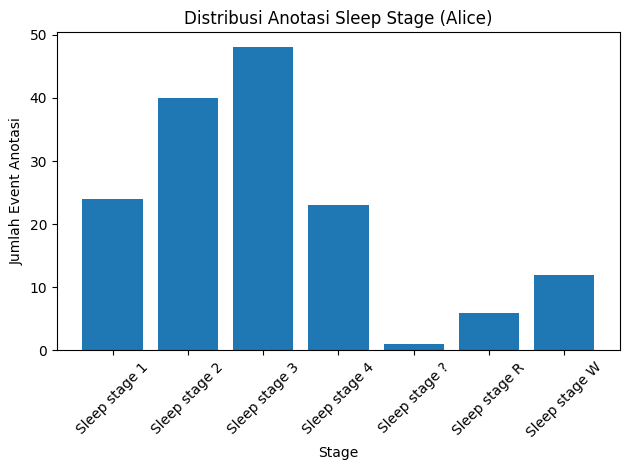

In [ ]:
labels, counts = np.unique(annot_train.description, return_counts=True)

df_annot_counts = pd.DataFrame({
    "Stage": labels,
    "Count": counts
}).sort_values("Stage").reset_index(drop=True)
display(df_annot_counts)

plt.figure()
plt.bar(df_annot_counts["Stage"], df_annot_counts["Count"])
plt.xticks(rotation=45)
plt.title("Distribusi Anotasi Sleep Stage (Alice)")
plt.xlabel("Stage")
plt.ylabel("Jumlah Event Anotasi")
plt.tight_layout()
plt.show()

,Stage,Count
0,Sleep stage 1,33
1,Sleep stage 2,40
2,Sleep stage 3,21
3,Sleep stage 4,8
4,Sleep stage ?,1
5,Sleep stage R,8
6,Sleep stage W,15


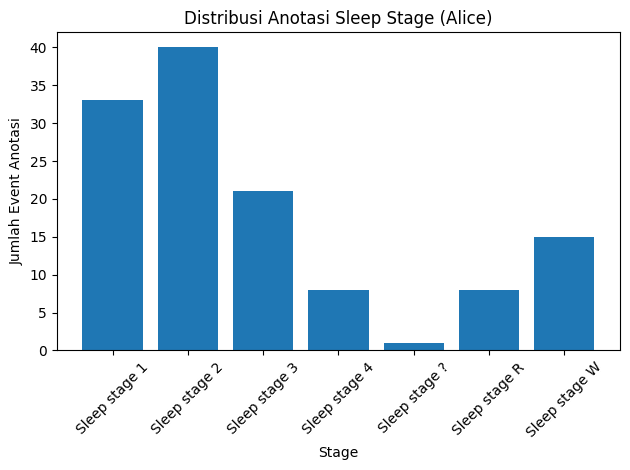

In [ ]:
labels, counts = np.unique(annot_test.description, return_counts=True)

df_annot_counts = pd.DataFrame({
    "Stage": labels,
    "Count": counts
}).sort_values("Stage").reset_index(drop=True)
display(df_annot_counts)

plt.figure()
plt.bar(df_annot_counts["Stage"], df_annot_counts["Count"])
plt.xticks(rotation=45)
plt.title("Distribusi Anotasi Sleep Stage (Alice)")
plt.xlabel("Stage")
plt.ylabel("Jumlah Event Anotasi")
plt.tight_layout()
plt.show()

,Stage,Duration_sec
0,Sleep stage 1,1740.0
1,Sleep stage 2,7500.0
2,Sleep stage 3,3030.0
3,Sleep stage 4,3570.0
4,Sleep stage ?,6900.0
5,Sleep stage R,3750.0
6,Sleep stage W,59910.0


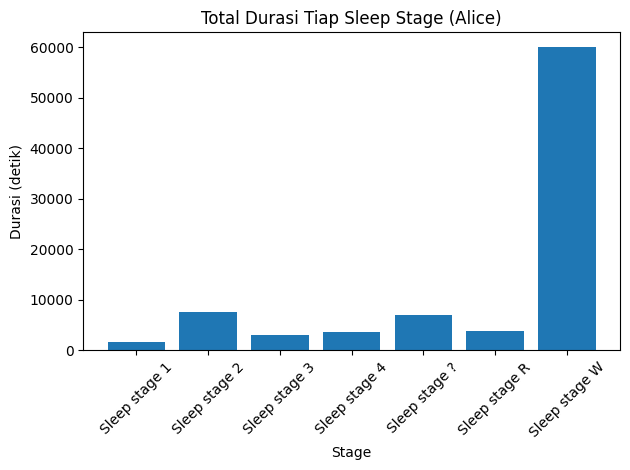

In [ ]:
durations = np.array([a["duration"] for a in annot_train])

df_annot = pd.DataFrame({
    "Stage": annot_train.description,
    "Duration_sec": durations
})
df_stage_dur = df_annot.groupby("Stage")["Duration_sec"].sum().reset_index()
df_stage_dur = df_stage_dur.sort_values("Stage")
display(df_stage_dur)

plt.figure()
plt.bar(df_stage_dur["Stage"], df_stage_dur["Duration_sec"])
plt.xticks(rotation=45)
plt.title("Total Durasi Tiap Sleep Stage (Alice)")
plt.xlabel("Stage")
plt.ylabel("Durasi (detik)")
plt.tight_layout()
plt.show()

,Stage,Duration_sec
0,Sleep stage 1,3270.0
1,Sleep stage 2,16860.0
2,Sleep stage 3,2880.0
3,Sleep stage 4,270.0
4,Sleep stage ?,2340.0
5,Sleep stage R,5100.0
6,Sleep stage W,55680.0


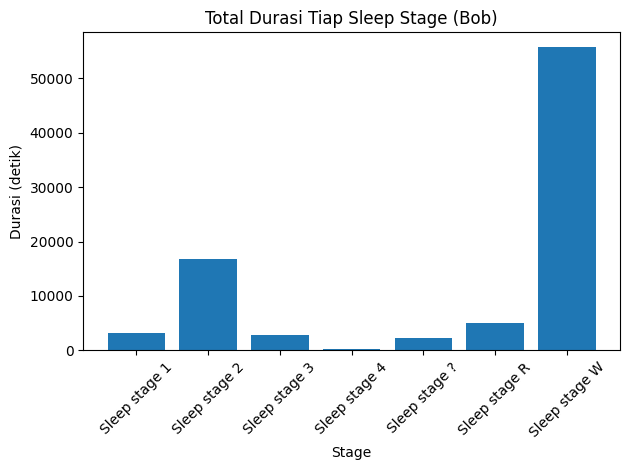

In [ ]:
durations = np.array([a["duration"] for a in annot_test])

df_annot = pd.DataFrame({
    "Stage": annot_test.description,
    "Duration_sec": durations
})
df_stage_dur = df_annot.groupby("Stage")["Duration_sec"].sum().reset_index()
df_stage_dur = df_stage_dur.sort_values("Stage")
display(df_stage_dur)

plt.figure()
plt.bar(df_stage_dur["Stage"], df_stage_dur["Duration_sec"])
plt.xticks(rotation=45)
plt.title("Total Durasi Tiap Sleep Stage (Bob)")
plt.xlabel("Stage")
plt.ylabel("Durasi (detik)")
plt.tight_layout()
plt.show()

### Distribusi Sleep Stage

Anotasi tidur dianalisis untuk memahami proporsi masing-masing *sleep stage*. Terdapat tujuh label utama: Sleep Stage W (Wake), Sleep Stage 1, Sleep Stage 2, Sleep Stage 3, Sleep Stage 4, Sleep Stage R (REM), dan Sleep Stage ?. Grafik “Distribusi Anotasi Sleep Stage” menunjukkan bahwa Sleep Stage 2 dan Stage 3 memiliki jumlah event tertinggi, sementara Stage 1 dan Stage R memiliki jumlah event yang jauh lebih sedikit. Adanya satu event Sleep Stage “?” mengindikasikan kesalahan anotasi atau sampel yang tidak dapat diklasifikasikan.

Analisis durasi total per sleep stage memberikan gambaran yang lebih jelas. Sleep Stage W memiliki durasi paling panjang, yaitu sekitar 59.910 detik (16,6 jam). Hal ini sesuai ekspektasi karena file raw PSG mencakup perekaman panjang sebelum dan sesudah tidur. Durasi tahapan lainnya konsisten dengan pola tidur normal dan menunjukkan bahwa data bersifat **imbalanced**, yang perlu diperhatikan pada tahap pemodelan.

Using matplotlib as 2D backend.


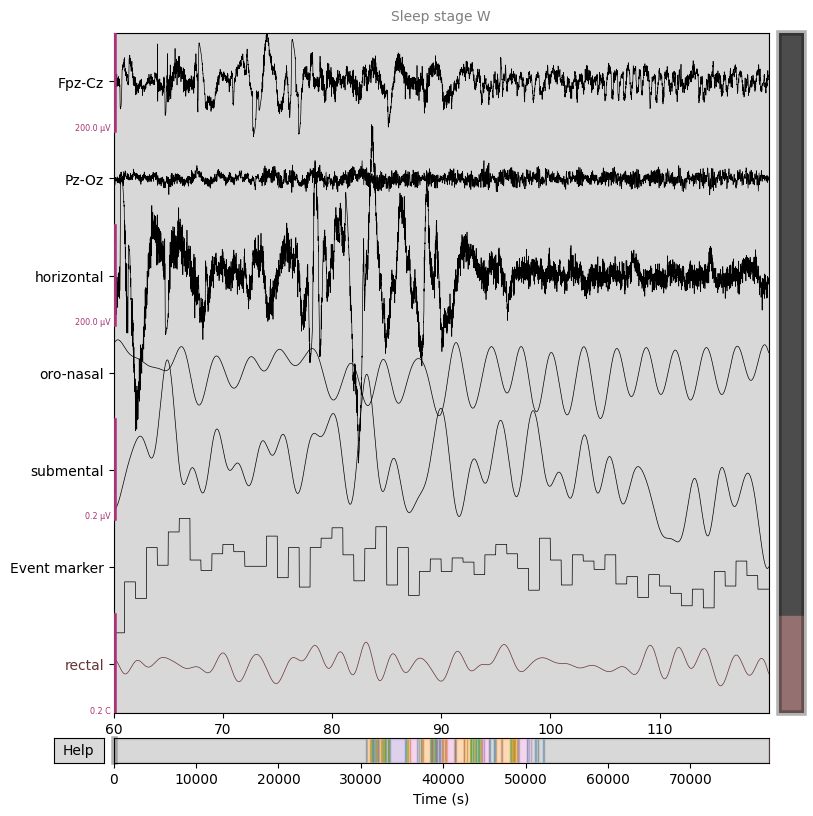

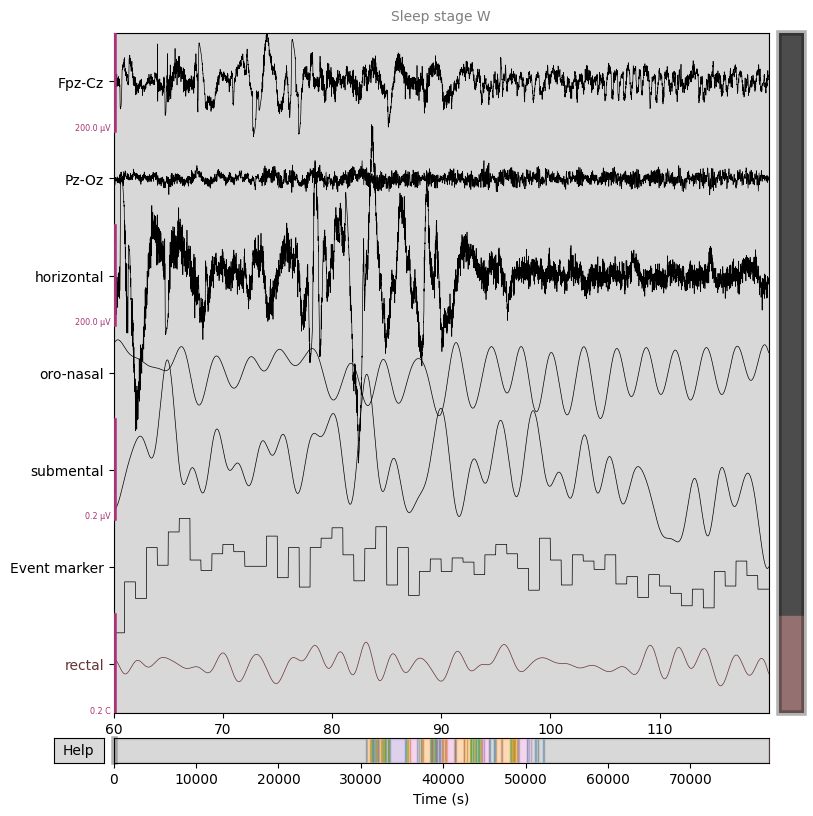

In [ ]:
raw_train.plot(
    start=60,
    duration=60,
    scalings=dict(
        eeg=1e-4,
        eog=1e-4,
        emg=1e-7,
        resp=1e3,
        misc=1e-1
    )
)

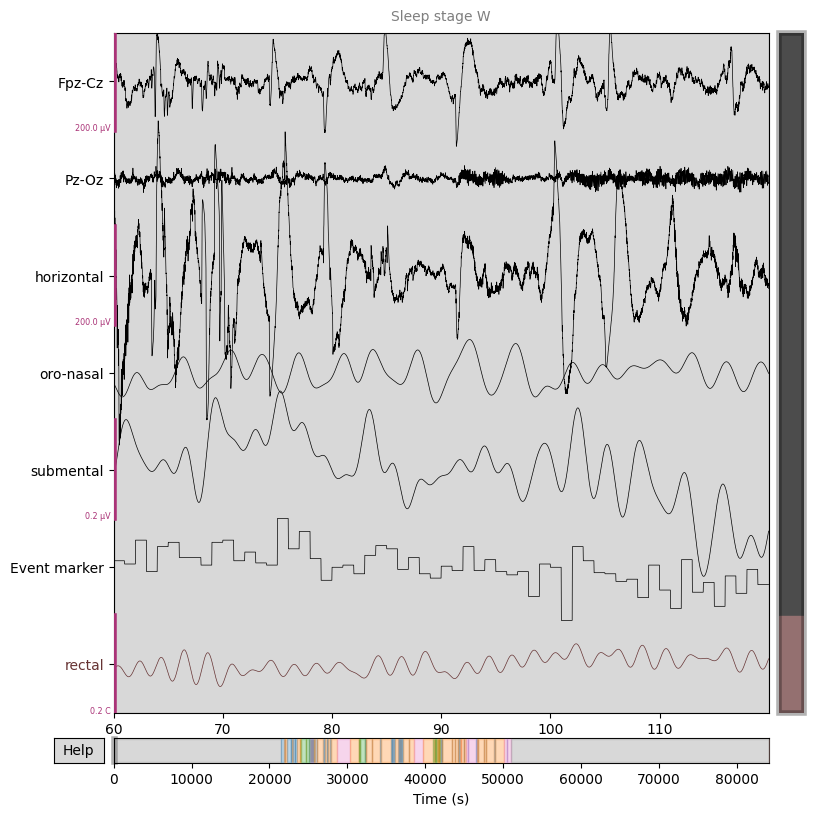

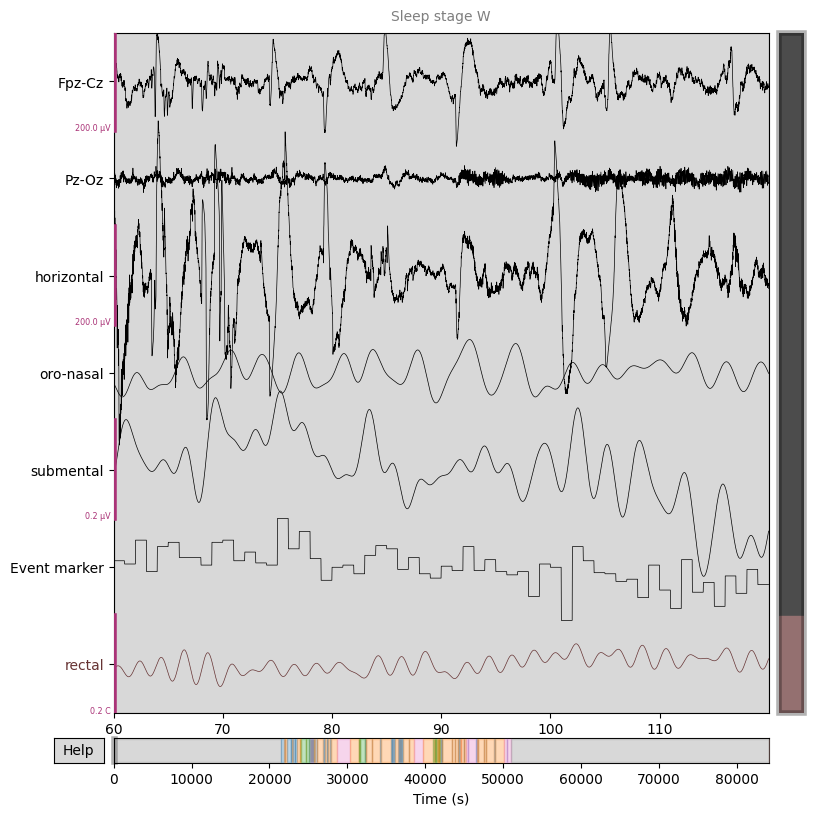

In [ ]:
raw_test.plot(
    start=60,
    duration=60,
    scalings=dict(
        eeg=1e-4,
        eog=1e-4,
        emg=1e-7,
        resp=1e3,
        misc=1e-1
    )
)

### Visualisasi Sinyal Mentah

Visualisasi 60 detik sinyal mentah memperlihatkan dinamika EEG, EOG, dan kanal respirasi dengan jelas. Kanal EEG menampilkan osilasi khas dengan amplitude mikrovolt, kanal EOG menunjukkan perubahan cepat terkait gerakan mata, kanal EMG memiliki amplitude rendah sesuai penurunan tonus otot saat tidur, sedangkan respirasi memperlihatkan pola sinusoidal stabil. Tidak ditemukan kanal yang *flat* atau menunjukkan noise ekstrem, sehingga seluruh kanal dinilai layak digunakan pada tahap preprocessing.

Cuplikan 10 detik sinyal EEG dua kanal (Fpz–Cz dan Pz–Oz) memperlihatkan perbedaan pola antara elektroda frontal dan posterior, yang penting untuk mengenali perubahan frekuensi spesifik pada tiap *sleep stage*.

,Channel,Mean,Std,Min,Max
0,Fpz-Cz,1.655056e-07,2.590938e-05,-1.920000e-04,0.000171
1,Pz-Oz,-3.508537e-07,1.142604e-05,-1.710879e-04,0.000196
2,horizontal,8.605218e-07,7.333069e-05,-5.117687e-04,0.000517
3,oro-nasal,1.269654e+02,1.715959e+02,-2.006586e+03,1928.108556
4,submental,2.950011e-06,9.569469e-07,-5.089877e-07,0.000004
5,rectal,3.698222e+01,3.672271e-01,3.470797e+01,37.561166
6,Event marker,8.583774e+02,3.607191e+01,1.360000e+02,980.000000


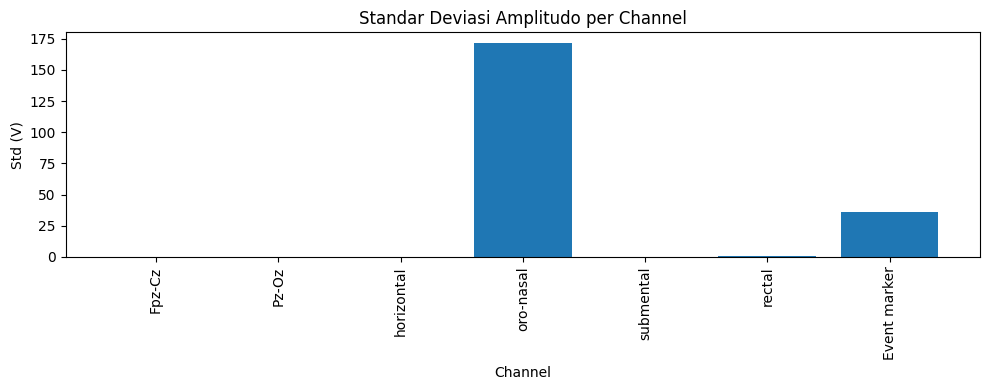

In [ ]:
full_data, _ = raw_train[:]

df_stats = pd.DataFrame({
    "Channel": ch_names,
    "Mean": full_data.mean(axis=1),
    "Std": full_data.std(axis=1),
    "Min": full_data.min(axis=1),
    "Max": full_data.max(axis=1),
})
display(df_stats)

plt.figure(figsize=(10, 4))
plt.bar(df_stats["Channel"], df_stats["Std"])
plt.xticks(rotation=90)
plt.title("Standar Deviasi Amplitudo per Channel")
plt.xlabel("Channel")
plt.ylabel("Std (V)")
plt.tight_layout()
plt.show()

### Statistik Amplitudo antar Kanal

Analisis statistik (mean, standar deviasi, minimum, maksimum) memberikan gambaran kualitas sinyal. Grafik “Standar Deviasi Amplitudo per Channel” menunjukkan bahwa kanal EEG memiliki standar deviasi rendah (orde 10⁻⁵ V), kanal EOG sedikit lebih besar, sementara kanal respirasi memiliki standar deviasi paling tinggi karena skalanya berbeda dan mengukur aliran udara. Kanal EMG submental memiliki amplitudo sangat rendah karena tonus otot minimal pada tidur. Pola ini normal dan menandakan bahwa sinyal berada dalam kisaran fisiologis yang wajar dan tidak terdapat kanal yang rusak.

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


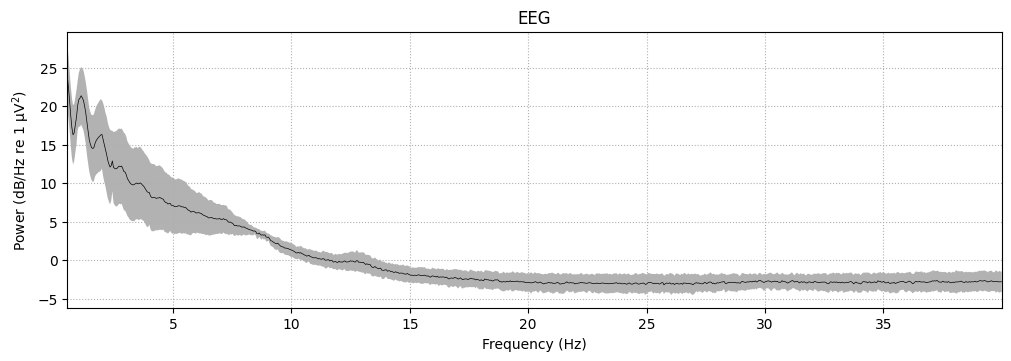

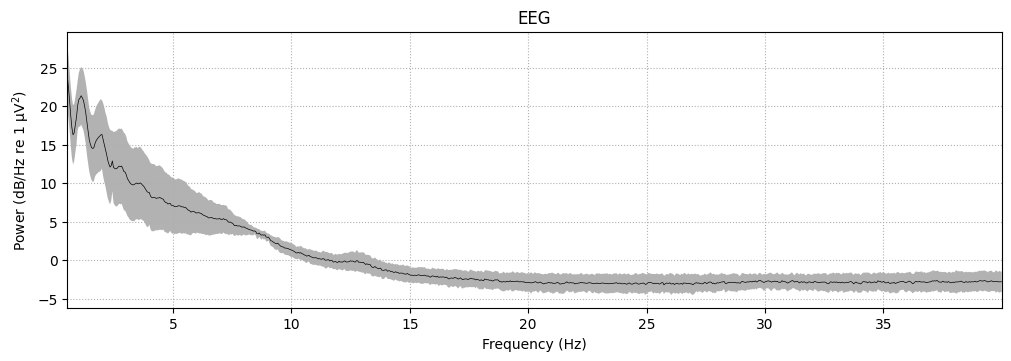

In [ ]:
psd = raw_train.compute_psd(fmin=0.5, fmax=40.0)
psd.plot(average=True)

### Power Spectral Density (PSD)

Analisis PSD dari kanal EEG memperlihatkan dominasi frekuensi rendah (0,5–4 Hz, band delta), diikuti frekuensi theta (4–8 Hz) dan alpha (8–12 Hz). Pola ini konsisten dengan karakteristik tidur dalam dan transisi tidur. Penurunan energi pada band frekuensi tinggi (15–30 Hz) menunjukkan berkurangnya aktivitas kognitif dan motorik pada tidur malam hari. Hal ini mengonfirmasi bahwa dataset valid dan memiliki properti spektral khas untuk *sleep stage classification*.

## Kesimpulan EDA

Berdasarkan hasil EDA, dapat disimpulkan bahwa dataset PSG yang digunakan:
1. Lengkap dan representatif dengan komposisi kanal EEG/EOG/EMG/respirasi sesuai standar polisomnografi.
2. Memiliki durasi rekaman panjang sehingga memerlukan *cropping* pada tahap preprocessing.
3. Mengandung *sleep stage* yang tidak seimbang (dominan W, N2, N3), yang akan berdampak pada desain model dan strategi training.
4. Menunjukkan kualitas sinyal yang baik tanpa kanal rusak, dibuktikan oleh visualisasi dan statistik amplitudo.
5. Memiliki pola PSD yang sesuai fenomena fisiologis tidur sehingga layak digunakan untuk pembangunan model CNN/LSTM berbasis sinyal EEG.

Dengan demikian, dataset telah dipahami secara menyeluruh dan dapat dilanjutkan ke tahap preprocessing (filtering, epoching 30 detik, normalisasi) sebelum masuk ke pemodelan deep learning.

## Data Preprocessing Train

In [ ]:

from sklearn.metrics import accuracy_score, classification_report

#### Load 7 Subjects (6 Train 1 Val)

In [ ]:
def load_subjects_train(num_subjects):
  """Pemilihan subject Train & Validation"""
  subjects = list(range(num_subjects))

  skip = {36, 39, 68, 69, 78, 79}

  filtered_subjects = [s for s in subjects if s not in skip]

  n_total = len(filtered_subjects)

  n_train = int(n_total * 0.9)

  train_subjects = filtered_subjects[:n_train]
  val_subjects   = filtered_subjects[n_train:]

  print(f"Total: {n_total} -> Train: {len(train_subjects)}, Val: {len(val_subjects)}")

  return train_subjects, val_subjects

In [ ]:
train_subjects, val_subjects = load_subjects_train(7)

print(f"Requested train subjects: {train_subjects}")
print(f"Requested val subjects  : {val_subjects}")

Total: 7 -> Train: 6, Val: 1
Requested train subjects: [0, 1, 2, 3, 4, 5]
Requested val subjects  : [6]


In [ ]:
def load_subject_files(subject_list):
    """Fetch pair data PSG dan HYP subject dari Dataset MNE"""
    file_pairs = fetch_data(subjects=subject_list, recording=[1])

    psg_files = [pair[0] for pair in file_pairs]
    hyp_files = [pair[1] for pair in file_pairs]

    return psg_files, hyp_files

In [ ]:
def load_raws(psg_files, hyp_files):
  """Load data raw dari input file PSG dan HYP"""
  raws_list = []
  for psg, hyp in zip(psg_files, hyp_files):
    raw = mne.io.read_raw_edf(
        psg,
        stim_channel="Event marker",
        infer_types=True,
        preload=True,
        verbose="error"
    )
    annotations = mne.read_annotations(hyp)
    raw.set_annotations(annotations, emit_warning=False)
    raws_list.append(raw)

  return raws_list

In [ ]:
train_psg, train_hyp = load_subject_files(train_subjects)
val_psg,   val_hyp   = load_subject_files(val_subjects)

Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 69.0GB/s]
100%|█████████████████████████████████████| 4.80k/4.80k [00:00<00:00, 4.82MB/s]
100%|█████████████████████████████████████| 51.4M/51.4M [00:00<00:00, 75.0GB/s]
100%|█████████████████████████████████████| 3.70k/3.70k [00:00<00:00, 2.16MB/s]
100%|█████████████████████████████████████| 46.9M/46.9M [00:00<00:00, 41.7GB/s]
100%|█████████████████████████████████████| 4.83k/4.83k [00:00<00:00, 7.27MB/s]
100%|█████████████████████████████████████| 49.7M/49.7M [00:00<00:00, 50.0GB/s]
100%|█████████████████████████████████████| 3.98k/3.98k [00:00<00:00, 2.90MB/s]

Download complete in 11m13s (189.9 MB)
Using default location ~/mne_data for PHYSIONET_SLEEP...



100%|█████████████████████████████████████| 50.5M/50.5M [00:00<00:00, 68.7GB/s]
100%|█████████████████████████████████████| 2.62k/2.62k [00:00<00:00, 1.47MB/s]

Download complete in 02m40s (48.2 MB)


In [ ]:
train_raws = load_raws(train_psg, train_hyp)
print(f"Loaded {len(train_raws)} train subjects")

Loaded 6 train subjects


In [ ]:
val_raws = load_raws(val_psg, val_hyp)
print(f"Loaded {len(val_raws)} validation subjects")

Loaded 1 validation subjects


### Preprocessing Steps

1. Standardize Sleep Stage Labels

    Label asli dari PhysioNet tidak selalu konsisten (W, 1, 2, 3, R). Kita akan menyamakan label untuk menghindari "label confusion". Ini akan meningkatkan training stability dan mencegah error saat evaluation.

2. Filtering (Bandpass 0.3 - 30 Hz)

    Sinyal EEG memiliki noise:

    - DC drift (<0.3 Hz)

    - Muscle noise (>30 Hz)

    - Electrical noise (50/60 Hz)

    Band 0.3–30 Hz adalah range utama gelombang otak tidur:

    - Delta (0.5–4 Hz) → N3

    - Theta (4–7 Hz) → N1, N2

    - Alpha (8–12 Hz) → Wake

    - Beta (13–30 Hz) → REM/Wake pattern

    Signal menjadi lebih bersih dan fokus pada fitur gelombang tidur yang benar-benar dipakai model yang akhirnay akan meningkatkan accuracy dan mengurangi overfitting pada noise

3. Epoching (Segmentasi per 30 detik)

    Sleep stage rules (AASM) mendefinisikan 1 label per 30 detik.
    Jadi:

    - Sinyal 30 detik = 1 input sample

    - Label = sleep stage pada durasi itu

    Tanpa epoching, model tidak bisa memahami struktur 1-segment = 1 label.

    Model mendapat input dengan ukuran tetap (fixed-length windows) sehingga bisa:

    - Diekstraksi fitur secara konsisten

    - Diproses oleh Model DL

In [ ]:
event_id = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage R': 4
}

def get_true_labels_30s(raw, event_id):
    sfreq = raw.info['sfreq']
    epoch_len_samples = int(30 * sfreq)
    annots = raw.annotations

    n_epochs = raw.n_times // epoch_len_samples
    y = []

    for i in range(n_epochs):
        start_time = i * 30.0
        stop_time = start_time + 30.0

        overlapping = []
        for a in annots:
            a_start = a['onset']
            a_end = a['onset'] + a['duration']
            if not (a_end <= start_time or a_start >= stop_time):
                overlapping.append(a)

        if len(overlapping) == 0:
            y.append(-1)
        else:
            desc = overlapping[0]['description']
            y.append(event_id.get(desc, -1))

    return np.array(y)

def preprocess_raw(raw, event_id, epoch_len_sec=30, dtype=np.float32):
    raw.filter(0.3, 35.0, fir_design='firwin', verbose="error")

    data = raw.get_data()
    sfreq = raw.info['sfreq']
    n_channels, n_times = data.shape
    epoch_len_samples = int(epoch_len_sec * sfreq)
    n_epochs = n_times // epoch_len_samples

    X = np.empty((n_epochs, n_channels, epoch_len_samples), dtype=dtype)

    for i in range(n_epochs):
        start = i * epoch_len_samples
        stop = start + epoch_len_samples
        X[i] = data[:, start:stop]

    y = get_true_labels_30s(raw, event_id)

    return X, y

In [ ]:
X_train_list = []
y_train_list = []

for raw in train_raws:
    X, y = preprocess_raw(raw, event_id)
    X_train_list.append(X)
    y_train_list.append(y)

In [ ]:
X_val_list = []
y_val_list = []

for raw in val_raws:
    X, y = preprocess_raw(raw, event_id)
    X_val_list.append(X)
    y_val_list.append(y)

In [ ]:
X_train_epochs = np.concatenate(X_train_list, axis=0)
y_train_epochs = np.concatenate(y_train_list, axis=0)
X_val_epochs = np.concatenate(X_val_list, axis=0)
y_val_epochs = np.concatenate(y_val_list, axis=0)

print("X_train_epochs:", X_train_epochs.shape)
print("y_train_epochs:", y_train_epochs.shape)
print("X_val_epochs:", X_val_epochs.shape)
print("y_val_epochs:", y_val_epochs.shape)

X_train_epochs: (16368, 7, 3000)
y_train_epochs: (16368,)
X_val_epochs: (2770, 7, 3000)
y_val_epochs: (2770,)


In [ ]:
del train_raws
del val_raws
del X_train_list
del y_train_list
del X_val_list
del y_val_list

### Normalize

EEG setiap orang punya skala amplitude yang berbeda karena:

- Ketebalan kulit

- Resistansi elektroda

- Jarak ke cortex

- Noise per device

Jika tidak distandardisasi, model bisa misinterpret amplitude sebagai fitur (padahal bukan).

Z-score membuat setiap epoch punya:

- Mean = 0

- Std = 1

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
def scale_epochs(X_epochs):
  n_epochs, n_channels, n_times = X_epochs.shape

  scalers = []
  for ch in range(n_channels):
      scaler = StandardScaler()
      scaler.fit(X_epochs[:, ch, :].reshape(-1, 1))
      scalers.append(scaler)

  for i in range(n_epochs):
      scaled_epoch = np.zeros_like(X_epochs[i], dtype=np.float32)
      for ch in range(n_channels):
          scaled_epoch[ch, :] = scalers[ch].transform(X_epochs[i, ch, :].reshape(-1, 1)).flatten()
      yield scaled_epoch

X_train_epochs = scale_epochs(X_train_epochs)
X_train_epochs = list(X_train_epochs)
X_val_epochs = scale_epochs(X_val_epochs)
X_val_epochs = list(X_val_epochs)

In [ ]:
X_train_epochs = np.array(X_train_epochs, dtype=np.float16)
X_val_epochs   = np.array(X_val_epochs, dtype=np.float16)

X_train_epochs = np.transpose(X_train_epochs, (0, 2, 1))
X_val_epochs = np.transpose(X_val_epochs, (0, 2, 1))

In [ ]:
X_train = X_train_epochs
X_val = X_val_epochs

y_train = y_train_epochs
y_val = y_val_epochs

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (16368, 3000, 7)
y_train: (16368,)
X_val: (2770, 3000, 7)
y_val: (2770,)


In [ ]:
del X_train_epochs
del y_train_epochs
del X_val_epochs
del y_val_epochs

In [ ]:
def augment_data(x, y):
  """Melakukan augmentasi acak pada sinyal EEG."""

  if tf.random.uniform([]) < 0.5:
      scale_factor = tf.random.uniform([], minval=0.8, maxval=1.2)
      x = x * scale_factor

  if tf.random.uniform([]) < 0.5:
      shift = tf.random.uniform([], minval=-50, maxval=50, dtype=tf.int32)
      x = tf.roll(x, shift, axis=1)

  if tf.random.uniform([]) < 0.5:
      noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.05)
      x = x + noise

  if tf.random.uniform([]) < 0.3:
      indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
      shuffled_indices = tf.random.shuffle(indices)
      x = tf.gather(x, shuffled_indices, axis=0)

  return x, y

In [ ]:
import tensorflow as tf

In [ ]:
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)

X_train, y_train = augment_data(X_train, y_train)

X_train = X_train.numpy() if isinstance(X_train, tf.Tensor) else X_train

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_integer = y_train
num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_val   = to_categorical(y_val, num_classes)

print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

y_train: (16368, 5)
y_val: (2770, 5)


In [ ]:
kernels = 1
chans = 7
samples = 3000

X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_val   = X_val.reshape(X_val.shape[0], chans, samples, kernels)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

X_train: (16368, 7, 3000, 1)
X_val: (2770, 7, 3000, 1)


## Modeling

### Model Building (EEGNet)

In [ ]:
!wget https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py

--2025-12-16 12:18:35--  https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18033 (18K) [text/plain]
Saving to: ‘EEGModels.py’

EEGModels.py        100%[===================>]  17.61K  --.-KB/s    in 0s      

2025-12-16 12:18:36 (74.7 MB/s) - ‘EEGModels.py’ saved [18033/18033]



In [ ]:
from EEGModels import EEGNet

In [ ]:
model = EEGNet(nb_classes = 5,
                Chans = chans,
                Samples = samples,
                dropoutRate = 0.4,
                kernLength = 32,
                # F1 = 8,
                F1 = 16,
                D = 2,
                # F2 = 16,
                F2 = 32,
                dropoutType = 'Dropout'
              )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
              loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(5e-5),
              metrics = ['accuracy']
            )
numParams    = model.count_params()

In [ ]:
from sklearn.utils import compute_class_weight

In [ ]:
classes = np.unique(y_train_integer)
class_weights_array = compute_class_weight(
  'balanced',
  classes=classes,
  y=y_train_integer
)
class_weights = dict(enumerate(class_weights_array))

print("Class Weights Baru:", class_weights)

Class Weights Baru: {0: np.float64(15.953216374269006), 1: np.float64(0.23598615916955018), 2: np.float64(5.12781954887218), 3: np.float64(1.0182904068682344), 4: np.float64(5.511111111111111), 5: np.float64(2.9301825993555317)}


In [ ]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='eeg_net.keras', verbose=1,
            save_best_only=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=8, restore_best_weights=True
        )
    ]

In [ ]:
fittedModel = model.fit(X_train,
                        y_train,
                        batch_size = 32,
                        epochs = 100,
                        verbose = 1,
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        class_weight = class_weights
                      )

Epoch 1/100
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6653 - loss: 8.7188
Epoch 1: val_loss improved from inf to 0.93363, saving model to eeg_net.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.6653 - loss: 8.7128 - val_accuracy: 0.6747 - val_loss: 0.9336 - learning_rate: 5.0000e-05
Epoch 2/100
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7417 - loss: 3.1993
Epoch 2: val_loss improved from 0.93363 to 0.59957, saving model to eeg_net.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.7417 - loss: 3.1987 - val_accuracy: 0.7758 - val_loss: 0.5996 - learning_rate: 5.0000e-05
Epoch 3/100
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7817 - loss: 2.6428
Epoch 3: val_loss improved from 0.59957 to 0.55849, saving model to eeg_net.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.7817 - loss: 2.6425 - val_accuracy: 0.7888 - val_loss: 0.5585 - learning_rate: 5.0000e-05
Epoch 4/100
510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [ ]:
del X_train
del y_train
del X_val
del y_val

## Data Preprocessing Test

Copy eeg_net.keras to Content Folder

#### Load 2 Test Subjects

In [ ]:
def load_subjects_test(num_subjects, n_test):
  """Pemilihan subject Test"""
  subjects = list(range(num_subjects))
  skip = {36, 39, 68, 69, 78, 79}

  filtered = [s for s in subjects if s not in skip]

  test_subjects = filtered[-n_test:]

  return test_subjects

In [ ]:
test_subjects  = load_subjects_test(82, 2)
print(f"Requested test subjects: {test_subjects}")

Requested test subjects: [80, 81]


In [ ]:
test_psg,  test_hyp  = load_subject_files(test_subjects)

Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.6M/50.6M [00:00<00:00, 77.2GB/s]
100%|█████████████████████████████████████| 4.93k/4.93k [00:00<00:00, 3.59MB/s]
100%|█████████████████████████████████████| 43.8M/43.8M [00:00<00:00, 70.4GB/s]
100%|█████████████████████████████████████| 6.51k/6.51k [00:00<00:00, 6.90MB/s]

Download complete in 05m04s (90.1 MB)


In [ ]:
test_raws = load_raws(test_psg, test_hyp)
print(f"\nLoaded {len(test_raws)} test subjects")


Loaded 2 test subjects


In [ ]:
X_test_list = []
y_test_list = []

for raw in test_raws:
  X, y = preprocess_raw(raw, event_id)
  X_test_list.append(X)
  y_test_list.append(y)

In [ ]:
X_test_epochs = np.concatenate(X_test_list, axis=0)
y_test_epochs = np.concatenate(y_test_list, axis=0)

print("X_test_epochs :", X_test_epochs.shape)
print("y_test_epochs :", y_test_epochs.shape)

X_test_epochs : (5176, 7, 3000)
y_test_epochs : (5176,)


In [ ]:
del X_test_list
del y_test_list

In [ ]:
X_test_epochs  = list(scale_epochs(X_test_epochs))

In [ ]:
X_test_epochs  = np.array(X_test_epochs, dtype=np.float16)
X_test_epochs  = np.transpose(X_test_epochs,  (0, 2, 1))

In [ ]:
X_test = X_test_epochs
y_test = y_test_epochs
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_test : (5176, 3000, 7)
y_test : (5176,)


In [ ]:
del X_test_epochs
del y_test_epochs

In [ ]:
y_test  = to_categorical(y_test, num_classes)
print("y_test :", y_test.shape)

y_test : (5176, 5)


In [ ]:
X_test  = X_test.reshape(X_test.shape[0], chans, samples, kernels)
print("X_test :", X_test.shape)

X_test : (5176, 7, 3000, 1)


## Inference

### EEGNet

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Accuracy: 0.6557187017001546
              precision    recall  f1-score   support

           0       0.93      0.68      0.78      3290
           1       0.00      0.00      0.00       291
           2       0.46      0.86      0.59      1123
           3       0.00      0.00      0.00       102
           4       0.30      0.55      0.39       370

    accuracy                           0.66      5176
   macro avg       0.34      0.42      0.35      5176
weighted avg       0.71      0.66      0.66      5176



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


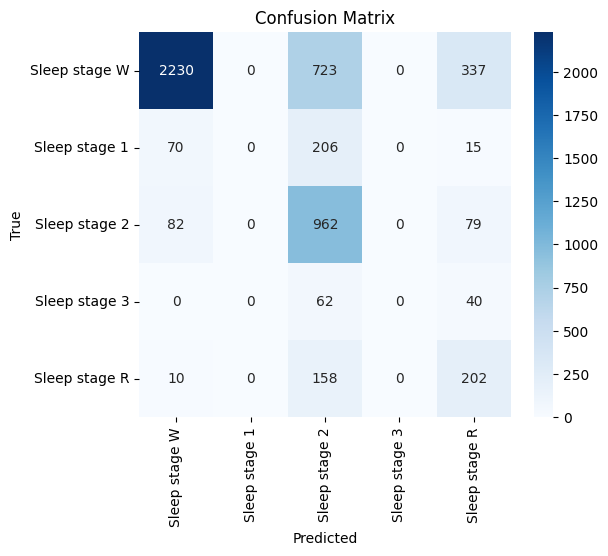

In [ ]:
probs = model.predict(X_test)
preds = probs.argmax(axis=-1)
if y_test.ndim > 1:
    y_true_integer = y_test.argmax(axis=-1)
else:
    y_true_integer = y_test

acc = np.mean(preds == y_true_integer)
print("\nAccuracy:", accuracy_score(y_true_integer, preds))
print(classification_report(y_true_integer, preds))

cm = confusion_matrix(y_true_integer, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=event_id.keys(), yticklabels=event_id.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### YASA

In [ ]:
!pip install yasa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.7/127.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.0 MB/s eta 0:00:00


In [ ]:
import yasa

In [ ]:
# ENCODE HASIL PREDIKSI YASA KE INT
YASA_TO_INT = {
    "W": 0,
    "N1": 1,
    "N2": 2,
    "N3": 3,
    "R": 4
}

In [ ]:
# DETEKSI CHANNEL EEG OTOMATIS
def detect_channels(raw):
  eeg = None
  eog = None
  emg = None

  for ch in raw.ch_names:
    ch_low = ch.lower()

    # EEG
    if eeg is None and any(k in ch_low for k in ["c3", "c4", "fz", "pz", "o1", "o2", "fp1", "fp2"]):
      eeg = ch

    # EOG
    if eog is None and any(k in ch_low for k in ["eog", "loc", "roc", "leog", "reog"]):
      eog = ch

    # EMG
    if emg is None and "emg" in ch_low:
      emg = ch

  return eeg, eog, emg

In [ ]:
# PREDICT SLEEP STAGES
def yasa_predict(raws):
  all_preds = []
  all_trues = []

  for raw in raws:
    eeg, eog, emg = detect_channels(raw)

    # PREDICT FUNCTION
    sls = yasa.SleepStaging(
      raw,
      eeg_name=eeg,
      eog_name=eog,
      emg_name=emg
    )

    preds = sls.predict()
    trues = get_true_labels_30s(raw, event_id)

    min_len = min(len(preds), len(trues))
    preds = preds[:min_len]
    trues = trues[:min_len]

    all_preds.extend(preds)
    all_trues.extend(trues)

  return np.array(all_preds), np.array(all_trues)

In [ ]:
y_pred_test,  y_true_test  = yasa_predict(test_raws)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
mask_test = y_true_test != -1
y_true_test = y_true_test[mask_test]
y_pred_test = y_pred_test[mask_test]

y_pred_test  = np.array([YASA_TO_INT[x] for x in y_pred_test])

Test Accuracy: 0.827954898911353
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3290
           1       0.50      0.19      0.28       291
           2       0.71      0.74      0.72      1123
           3       0.26      0.98      0.41       102
           4       0.75      0.79      0.77       338

    accuracy                           0.83      5144
   macro avg       0.64      0.72      0.62      5144
weighted avg       0.85      0.83      0.83      5144



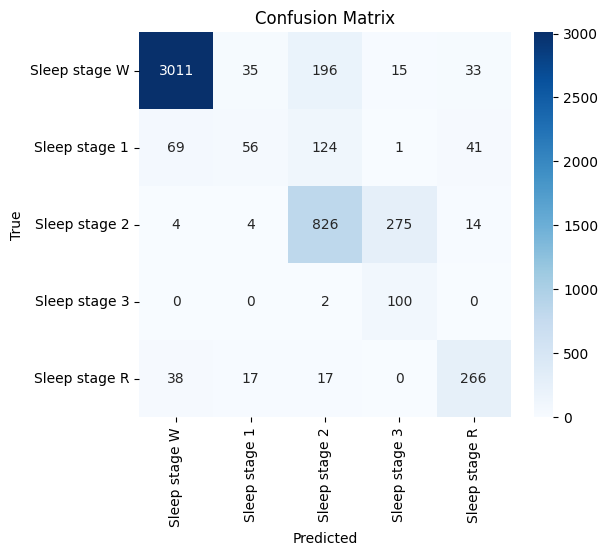

In [ ]:
print("Test Accuracy:", accuracy_score(y_true_test, y_pred_test))
print(classification_report(y_true_test, y_pred_test))
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=event_id.keys(), yticklabels=event_id.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()